In [2]:
# -*- coding: utf-8 -*-
from pandas_datareader import data as web
import numpy as np
import pandas as pd
from sklearn import mixture as mix
import seaborn as sns
import matplotlib.pyplot as plt
import talib as ta
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [3]:
df = web.get_data_yahoo('FCX', start='2000-01-01', end='2017-08-01')
df = df[['Open', 'High', 'Low', 'Close']]

n = 10
t = 0.8
split = int(t*len(df))

df['high'] = df['High'].shift(1)
df['low'] = df['Low'].shift(1)
df['close'] = df['Close'].shift(1)
df['RSI'] = ta.RSI(np.array(df['close']), timeperiod=n)
df['SMA'] = df['close'].rolling(window=n).mean()
df['Corr'] = df['SMA'].rolling(window=n).corr(df['close'])
df['SAR'] = ta.SAR(np.array(df['high']), np.array(df['low']), 0.2, 0.2)
df['ADX'] = ta.ADX(np.array(df['high']), np.array(df['low']), np.array(df['close']), timeperiod=n)
df['Corr'][df.Corr > 1] = 1
df['Corr'][df.Corr < -1] = -1
df['Return'] = np.log(df['Open']/df['Open'].shift(1))

print(df.head())

                Open      High       Low     Close      high       low  \
Date                                                                     
2000-01-03  10.53125  10.71875  10.37500  10.59375       NaN       NaN   
2000-01-04  10.46875  10.50000   9.96875  10.00000  10.71875  10.37500   
2000-01-05  10.03125  10.40625  10.03125  10.37500  10.50000   9.96875   
2000-01-06  10.37500  10.46875   9.90625  10.06250  10.40625  10.03125   
2000-01-07   9.93750  10.25000   9.65625   9.81250  10.46875   9.90625   

               close  RSI  SMA  Corr       SAR  ADX    Return  
Date                                                           
2000-01-03       NaN  NaN  NaN   NaN       NaN  NaN       NaN  
2000-01-04  10.59375  NaN  NaN   NaN       NaN  NaN -0.005952  
2000-01-05  10.00000  NaN  NaN   NaN  10.71875  NaN -0.042689  
2000-01-06  10.37500  NaN  NaN   NaN  10.56875  NaN  0.033694  
2000-01-07  10.06250  NaN  NaN   NaN  10.50000  NaN -0.043084  


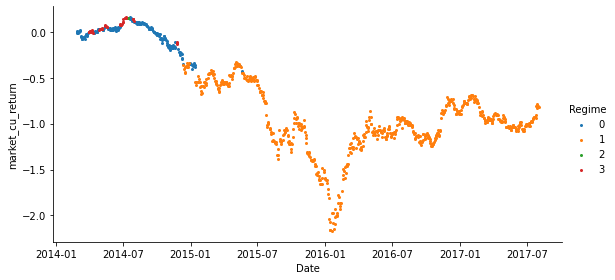

Mean for regime 0:  0.40729969433665214
Co-Variance for regime 0:  0.4193062337799184
Mean for regime 1:  -0.9460028041274552
Co-Variance for regime 1:  0.5452796810057393
Mean for regime 2:  1.58724775634675
Co-Variance for regime 2:  0.4160691542680498
Mean for regime 3:  0.5056966760842183
Co-Variance for regime 3:  0.2009722531460279
        Date  Regime       Open       high        low      close        RSI  \
0 2014-02-26       0  32.860001  33.130001  32.669998  32.770000  44.553163   
1 2014-02-27       0  33.380001  33.580002  32.840000  33.410000  52.525999   
2 2014-02-28       0  33.099998  33.509998  33.150002  33.470001  53.226605   
3 2014-03-03       0  32.709999  33.200001  32.410000  32.619999  43.193169   
4 2014-03-04       0  33.119999  33.160000  32.500000  32.830002  45.988112   

      SMA      Corr        SAR        ADX    Return  market_cu_return  
0  33.288 -0.006152  33.990002  21.705286 -0.006975         -0.006975  
1  33.310 -0.010600  33.726001  19.880628

In [4]:
df = df.dropna()
ss = StandardScaler()
unsup = mix.GaussianMixture(n_components=4,
                            covariance_type="spherical",
                            n_init=100,
                            random_state=42)
df = df.drop(['High', 'Low', 'Close'], axis=1)
unsup.fit(np.reshape(ss.fit_transform(df[:split]), (-1, df.shape[1])))
regime = unsup.predict(np.reshape(ss.transform(df[split:]), (-1, df.shape[1])))
Regimes = pd.DataFrame(regime, columns=['Regime'], index=df[split:].index).join(df[split:], how='inner').assign(market_cu_return=df[split:].Return.cumsum()).reset_index(drop=False).rename(columns={'index': 'Date'})
order = [0, 1, 2, 3]
fig = sns.FacetGrid(data=Regimes, hue='Regime', hue_order=order, aspect=2, height=4)
fig.map(plt.scatter, 'Date', 'market_cu_return', s=4).add_legend()
plt.show()

for i in order:
    print('Mean for regime %i: ' % i, unsup.means_[i][0])
    print('Co-Variance for regime %i: ' % i, (unsup.covariances_[i]))

print(Regimes.head())

ss1 = StandardScaler()
columns = Regimes.columns.drop(['Regime', 'Date'])
Regimes[columns] = ss1.fit_transform(Regimes[columns])
Regimes['Signal'] = 0
Regimes.loc[Regimes['Return'] > 0, 'Signal'] = 1
Regimes.loc[Regimes['Return'] < 0, 'Signal'] = -1
Regimes['return'] = Regimes['Return'].shift(1)
Regimes = Regimes.dropna()

In [5]:
cls = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf', max_iter=-1, probability=False, random_state=None, shrinking=True, tol=0.001, verbose=False)

In [6]:
split2 = int(.8*len(Regimes))

X = Regimes.drop(['Signal', 'Return', 'market_cu_return', 'Date'], axis=1)
y = Regimes['Signal']

In [7]:
cls.fit(X[:split2], y[:split2])
p_data = len(X)-split2

df['Pred_Signal'] = 0
df.iloc[-p_data:, df.columns.get_loc('Pred_Signal')] = cls.predict(X[split2:])

print(df['Pred_Signal'][-p_data:])

df['str_ret'] = df['Pred_Signal']*df['Return'].shift(-1)

df['strategy_cu_return'] = 0.
df['market_cu_return'] = 0.
df.iloc[-p_data:, df.columns.get_loc('strategy_cu_return')] \
       = np.nancumsum(df['str_ret'][-p_data:])
df.iloc[-p_data:, df.columns.get_loc('market_cu_return')] \
       = np.nancumsum(df['Return'][-p_data:])
Sharpe = (df['strategy_cu_return'][-1]-df['market_cu_return'][-1])/np.nanstd(df['strategy_cu_return'][-p_data:])

Date
2016-11-22    1
2016-11-23    1
2016-11-25    1
2016-11-28    1
2016-11-29    1
             ..
2017-07-26    1
2017-07-27    1
2017-07-28    1
2017-07-31    1
2017-08-01    1
Name: Pred_Signal, Length: 173, dtype: int64


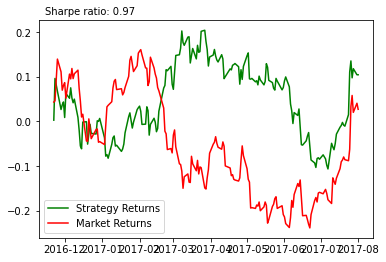

In [8]:
plt.plot(df['strategy_cu_return'][-p_data:], color='g', label='Strategy Returns')
plt.plot(df['market_cu_return'][-p_data:], color='r', label='Market Returns')
plt.figtext(0.14, 0.9, s='Sharpe ratio: %.2f' % Sharpe)
plt.legend(loc='best')
plt.show()
